# 第七周学习总结

本周任务：1、学习基础矩阵、外极空间的理论知识。
2、学习由基础矩阵和三维点计算照相机矩阵的理论知识。
3、进行多视图重建

计算三维重建的方法称为SfM（Structure from Motion）.\\
假设计算机已经标定，计算重建的部分可以分为下面四个步骤：\\
（1）、检测特征点，然后在两幅图间进行特征点匹配。\\
（2）、有匹配算出基础矩阵。\\
（3）、由基础矩阵计算照相机矩阵。\\
（4）、三角剖分这些三维点。

In [18]:
from PIL import Image
from numpy import *
from pylab import *

class RansacModel(object):
    def __init__(self,debug=False):
        self.debug = debug
    def fit(self,data):
        '''计算选取8个对应点计算基础矩阵F'''
        
        #转置并将数据分为两个类
        data = data.T
        
        x1 = data[:3,:8]
        
        x2 = data[3:,:8]
        
        F = compute_fundamental_normalized(x1,x2)
        return F
    
    def get_error(self,data,F):
        data = data.T
        
        x1 = data[:3]
        
        x2 = data[3:]
        #将Sampson距离作为误差度量
        Fx1 = dot(F,x1)
        Fx2 = dot(F,x2)
        denom = Fx1[0]*Fx1[0]+Fx1[1]*Fx1[1]+Fx2[0]*Fx2[0]+Fx2[1]*Fx2[1]
        err = (diag(dot(x1.T,dot(F,x2))))**2/denom
    
        return err

In [19]:
from PIL import Image
from numpy import *
from pylab import *

def compute_fundamental_normalized(x1,x2):
    '''使用归一化的八点算法，由对应点计算基础矩阵'''
    n=x1.shape[1]
    if x2.shape[1]!= n:
        raise ValueError("Number of points dont match.")
    
    x1 = x1/x1[2]
    mean_1 = mean(x1[:2],axis = 1)
    S1 = sqrt(2)/std(x1[:2])
    T1 = array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = dot(T1,x1)
   
    x2 = x2/x2[2]
    mean_2 = mean(x2[:2],axis = 1)
    S2 = sqrt(2)/std(x2[:2])
    T2 = array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = dot(T2,x2)
    
    #使用话的坐标计算F
    F = compute_fundamental(x1,x2)
    
    #反归一化
    F = dot(T1.T,dot(F,T2))
    return F/F[2,2]

In [20]:
from scipy import linalg
def compute_fundamental(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("number of points don't match.")
        
    A = zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i],x1[0,i]*x2[1,i],x1[0,i]*x2[2,i],
               x1[1,i]*x2[0,i],x1[1,i]*x2[1,i],x1[1,i]*x2[2,i],
               x1[2,i]*x2[0,i],x1[2,i]*x2[1,i],x1[2,i]*x2[2,i]]
        
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
    
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = dot(U,dot(diag(S),V))
    return F

In [27]:
def F_from_ransac(x1,x2,model,maxiter = 5000,match_theshold = 1e-6):
    import ransac
    data = vstack((x1,x2))
    F,ransac_data = ransac.ransac(data.T,model,8,maxiter,match_theshold,20,return_all=True)
    return F,ransac_data['inliers']

In [31]:
def skew(a):
    '''反对称矩阵A,使得对于每个v有a*v=Av'''
    return array([[0,-a[2],a[1]],[a[2],0,-a[0],[-a[1],a[0],0]]])
def compute_P_from_essential(E):
    '''从本质矩阵中计算第二个照相机矩阵
    输出四个可能的照相机矩阵列表'''
    
    U,S,V = svd(E)
    if det(dot(U,V))<0:
        V=-V
    E = dot(U,dot(diag([1,1,0]),V))
    
    #创建矩阵
    Z = skew([0,0,-1])
    W = array([[0,-1,0],[1,0,0],[0,0,1]])
    
    P2 = [vstack((dot(U,dot(W,V)).T,U[:,2])).T,
         vstack((dot(U,dot(W,V)).T,-U[:,2])).T,
         vstack((dot(U,dot(W.T,V)).T,U[:,2])).T,
         vstack((dot(U,dot(W.T,V)).T,-U[:,2])).T]
    
    return P2

In [32]:
from PIL import Image
from numpy import *
from pylab import *
import use

K = array([[3200,0,1499],[0,3194,2046],[0,0,1]])

im1 = array(Image.open('/Users/lenovo/Desktop/001.jpg'))
use.process_image('/Users/lenovo/Desktop/001.jpg','im1.sift')
l1,d1 = use.read_features_from_file('im1.sift')

im2 = array(Image.open('/Users/lenovo/Desktop/002.jpg'))
use.process_image('/Users/lenovo/Desktop/002.jpg','im2.sift')
l2,d2 = use.read_features_from_file('im2.sift')

matches = use.match_twosided(d1,d2)
ndx = matches.nonzero()[0]

#使用齐次坐标表示，并用inv（K）归一化
x1 = use.make_homog(l1[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = use.make_homog(l2[ndx2,:2].T)

x1n = dot(inv(K),x1)
x2n = dot(inv(K),x2)

#使用RANSAC方法估计E
model = RansacModel()
E,inliers = F_from_ransac(x1n,x2n,model)

#计算照相机矩阵
P1 = array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P2 = compute_P_from_essential(E)

processed tmp.pgm to im1.sift
processed tmp.pgm to im2.sift


In [33]:
print(P2)

[array([[ 0.08844546,  0.56116681, -0.82296368, -0.8223298 ],
       [ 0.54756402, -0.71755884, -0.43044507, -0.33362998],
       [-0.83207635, -0.41255439, -0.37073957,  0.46093896]]), array([[ 0.08844546,  0.56116681, -0.82296368,  0.8223298 ],
       [ 0.54756402, -0.71755884, -0.43044507,  0.33362998],
       [-0.83207635, -0.41255439, -0.37073957, -0.46093896]]), array([[ 0.9624123 ,  0.11680701, -0.24519114, -0.8223298 ],
       [-0.12121725,  0.99262171, -0.00291935, -0.33362998],
       [ 0.24304105,  0.03253101,  0.96947036,  0.46093896]]), array([[ 0.9624123 ,  0.11680701, -0.24519114,  0.8223298 ],
       [-0.12121725,  0.99262171, -0.00291935,  0.33362998],
       [ 0.24304105,  0.03253101,  0.96947036, -0.46093896]])]


In [34]:
def triangulate_point(x1,x2,P1,P2):
    '''使用最小二乘解'''
    M = zeros((6,6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2
    
    U,S,V = linalg.svd(M)
    X = V[-1,:4]
    
    return X/X[3]
def triangulate(x1,x2,P1,P2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("number of points dont match.")
    X = [triangulate_point(x1[:,i],x2[:,i],P1,P2)for i in range(n)]
    return array(X).T
    

In [35]:
ind = 0
maxres = 0
for i in range(4):
    #三角剖分正确点，并且计算每个照相机的深度
    X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[i])
    d1 = dot(P1,X)[2]
    d2 = dot(P2[i],X)[2]
    if sum(d1>0)+sum(d2>0)>maxres:
        maxres = sum(d1>0)+sum(d2>0)
        ind = i
        infront = (d1>0)&(d2>0)
    X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[ind])
    X = X[:,infront]

(0.5552878425664275,
 0.7850732881064073,
 -1.1467862526616306,
 -0.8664231543170393)

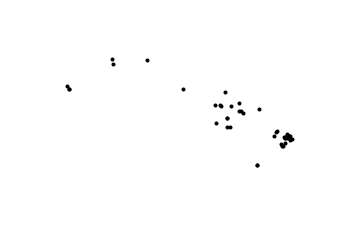

In [36]:
from mpl_toolkits.mplot3d import axes3d

fig =  figure()
ax = fig.gca(projection='3d')
ax.plot(-X[0],X[1],X[2],'k.')
axis('off')

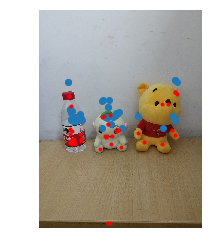

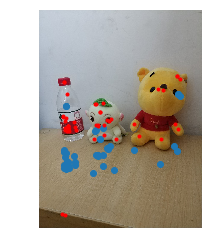

In [38]:
cam1 = use.Camera(P1)
cam2 = use.Camera(P2[ind])
x1p = cam1.project(X)
x2p = cam2.project(X)

x1p = dot(K,x1p)
x2p = dot(K,x2p)

figure()
imshow(im1)
gray()
plot(x1p[0],x1p[1],'o')
plot(x1[0],x1[1],'r.')
axis('off')

figure()
imshow(im2)
gray()
plot(x2p[0],x2p[1],'o')
plot(x2[0],x2[1],'r.')
axis('off')

show()

In [40]:
from scipy.cluster.vq import *